# MTC evaluation


### Summary

- Scalability analysis;
  
    
- Sensitivity analysis:
    - to class imbalance
    - to number of features

### Main takeaways


As expected, results from the scalability test are satisfying: 
- prediction time grows linearly with the size of the dataset,
- testing time remains (surprisingly) stable. 

Also as expected, MTC struggles with multicluster class (as it is more tailored for binary classification)
Results on the two batches when the number of cluster per class is 2 are generally poor:
- MCC of .3 in the best-case scenarios (50-50 classes and only 20 features) 
- MCC plummets to .1 ca as the dataset features get more challenging  
  
A similar trend is displayed by k-NN. 
The other algorithms appearing more robust - especially SVM - even though they all score very badly on the dataset with 95-5 imbalance. 

As for the results from the batches with one cluster per class:
- when it comes to imbalance, the MCC score is around .5 at the 80-20 imbalance ratio
- when it comes to number of features:
   - performance is close to the other algorithms' on the 20-features dataset
   - performance plummets as the 200-features threshold is passed - the other algorithms seem to react better. 

In [1]:
#import necessary items

#classes
from MTC2 import MTClust, MTClustT, MTClassifier

#libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, sample, seed
import time

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

from collections import defaultdict

#import algorithms
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 3.1. Scalability

To test how well would MTC scale:
1. A large dataset of 500k instances was generated;
2. Different subsample sizes were defined;
3. On each subsample:
    - MTC was run to fit and predict
    - Training and prediction times were recorded.

In [2]:
#creating large dataset 
X_st, y_st = make_classification(
    n_samples=500000,
    n_features=200,
    n_informative=20,
    n_redundant=20,
    
    n_classes=2,
    n_clusters_per_class=2,
    weights=[0.2,0.8],
    class_sep=0.,
    
    random_state=42)

#split
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X_st, y_st, test_size=0.25, random_state=42)

#MTC instance
mtc = MTClassifier(n_parts=10, max_depth=20, min_instances=5, use_binary_class=True, dist_func="euclidean")

#define subsample sizes
subsample_sizes = [0.1, 0.2, 0.5, 1.0]

In [3]:
#evaluating

#store training times, prediction times, MCC scores
train_times = []
predict_times = []
mcc_scores = []

#evaluate on subsamples
for size in subsample_sizes:
    
    sample_size = int(size * X_train_st.shape[0])
    X_subsample = X_train_st[:sample_size]
    y_subsample = y_train_st[:sample_size]

    start_time = time.time()
    mtc.fit(X_subsample, y_subsample)
    train_time = time.time() - start_time

    start_time = time.time()
    predictions = mtc.predict(X_test_st)
    predict_time = time.time() - start_time

    mcc = matthews_corrcoef(y_test_st, predictions)

    #store results
    train_times.append(train_time)
    predict_times.append(predict_time)
    mcc_scores.append(mcc)
    
    print(f"Size: {size:.2f}, Train time: {train_time:.4f}s, Predict time: {predict_time:.4f}s, MCC: {mcc:.4f}")

Binary classification
Size: 0.10, Train time: 10.3744s, Predict time: 19.1970s, MCC: 0.6931
Binary classification
Size: 0.20, Train time: 32.4178s, Predict time: 26.4152s, MCC: 0.7277
Binary classification
Size: 0.50, Train time: 87.5235s, Predict time: 27.0035s, MCC: 0.7505
Binary classification
Size: 1.00, Train time: 186.7643s, Predict time: 30.2461s, MCC: 0.7671


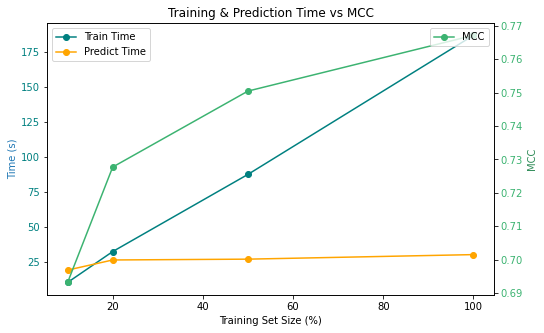

In [4]:
#plot
plot_size = (8, 5)
fig, ax1 = plt.subplots(figsize=plot_size)

ax1.set_xlabel('Training Set Size (%)')
ax1.set_ylabel('Time (s)', color='tab:blue')
ax1.plot([size*100 for size in subsample_sizes], train_times, label='Train Time', color='teal', marker='o')
ax1.plot([size*100 for size in subsample_sizes], predict_times, label='Predict Time', color='orange', marker='o')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('MCC', color='seagreen')
ax2.plot([size*100 for size in subsample_sizes], mcc_scores, label='MCC', color='mediumseagreen', marker='o')
ax2.tick_params(axis='y', labelcolor='mediumseagreen')
ax2.legend(loc='upper right')

plt.title('Training & Prediction Time vs MCC')
plt.show()

# 3.2. Sensitivity

We are interested in assessing how MTClassifier copes with 
- highly **imbalanced datasets**;
- a **high number** of **features**.

In order to gain insight on MTC's performance when facing such scenarios, we created **two sets** of - respectively - 5 and 4 datasets with *make_classification*: 
- in the first batch, we generated each dataset with two increasingly imbalanced classes, from a 50-50 to a 95-5 scenario;
- in the second batch, the sets were generated with 20, 200, 500 and 1000 features.

Also, both batches of datasets are run **twice**:
- first with classes featuring one cluster,
- then with classes featuring two clusters  
to gain further insight.

The evaluation procedure closely follows the one implemented for assessing overall performance: k-fold cross validation is set up, and the average metrics are computed for the k folds. 

In [62]:
#initialize algorithms in dictionary
rf = RandomForestClassifier(n_estimators=200, random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),learning_rate=0.1, n_estimators=200, random_state=42)
svm = SVC(C=10, probability=True, random_state=42)
knn = KNeighborsClassifier(metric='euclidean')
seed(11)
mtc = MTClassifier(n_parts=10, max_depth=20, min_instances=5, use_binary_class=True, dist_func="euclidean")


classifiers = {
    "Random Forest": rf,
    "AdaBoost": ada,
    "Support Vector Machine": svm,
    "k-Nearest Neighbors": knn,
    "MTClassifier": mtc
}

## 3.2.1. to Class imbalance

In [69]:
#create 5 datasets with increasingly imbalanced classes
def genDatasets(weights, n_samples=5000, n_features=40, n_informative=8, random_state=42):
    
    X, y = make_classification(n_samples=n_samples,
                               n_features=n_features,
                               n_informative=n_informative,
                               
                               n_classes=2,
                               n_clusters_per_class=1,
                               weights=weights,
                               flip_y=0.02,
                               class_sep=0.65,
                               
                               random_state=random_state)
    return X, y

#imbalance ratios
imbalance_ratios = [(0.5, 0.5), (0.67, 0.33), (0.80, 0.20), (0.9, 0.1), (0.95, 0.05)]
datasets = [genDatasets(weights) for weights in imbalance_ratios]

print("Datasets generated")

Datasets generated


In [70]:
#create results storage structure
results = {ratio: {"validation": defaultdict(list),
                   "test": defaultdict(float),
                   "time": defaultdict(float),
                   "average": defaultdict(dict)} for ratio in imbalance_ratios}

#looping through datasets 
for ratio, (X, y) in zip(imbalance_ratios, datasets):
    
    #train/test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #cross validation setup
    num_folds = 3
    fold_size = len(X_train) // num_folds
    
    metrics = {
        "Matthews Correlation Coefficient": {},
        "Cohen's Kappa Score": {},
        "Training Time": {},
        "Prediction Time": {}
    }

    for clf_name in classifiers.keys():
        for metric_name in metrics.keys():
            metrics[metric_name][clf_name] = []

    #train/val split
    for fold in range(num_folds):
        print(f"Dataset: {int(ratio[0]*100)}-{int(ratio[1]*100)}, Evaluating fold {fold + 1}...")

        val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
        train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
        
        X_val_fold = X_train[val_indices]
        y_val_fold = y_train[val_indices]
        X_train_fold = X_train[train_indices]
        y_train_fold = y_train[train_indices]
        
        #evaluate
        for clf_name, clf in classifiers.items():
            print(f"    Evaluating {clf_name}...")
            
            start_time = time.time()
            clf.fit(X_train_fold, y_train_fold)
            end_time = time.time()
            metrics["Training Time"][clf_name].append(end_time - start_time)
            
            start_time = time.time()
            y_pred = clf.predict(X_val_fold)
            end_time = time.time()
            metrics["Prediction Time"][clf_name].append(end_time - start_time)
            
            metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
            metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
            
            #results
            cohen_key = "Cohen's Kappa Score"
            print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
                  f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
            print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
                  f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

    #store results
    results[ratio]["validation"] = metrics


Dataset: 50-50, Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.815, Cohen's Kappa Score: 0.814
    Training Time: 2.147s, Prediction Time: 0.049s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.754, Cohen's Kappa Score: 0.754
    Training Time: 7.162s, Prediction Time: 0.047s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.746, Cohen's Kappa Score: 0.746
    Training Time: 1.999s, Prediction Time: 0.295s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.613, Cohen's Kappa Score: 0.613
    Training Time: 0.002s, Prediction Time: 0.101s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.601, Cohen's Kappa Score: 0.601
    Training Time: 0.400s, Prediction Time: 0.126s

Dataset: 50-50, Evaluating fold 2...
    Evaluating Random Fore

    MTClassifier - Matthews Correlation Coefficient: 0.476, Cohen's Kappa Score: 0.393
    Training Time: 0.449s, Prediction Time: 0.215s

Dataset: 90-10, Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.614, Cohen's Kappa Score: 0.560
    Training Time: 3.721s, Prediction Time: 0.043s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.557, Cohen's Kappa Score: 0.515
    Training Time: 10.613s, Prediction Time: 0.062s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.623, Cohen's Kappa Score: 0.597
    Training Time: 1.585s, Prediction Time: 0.389s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.367, Cohen's Kappa Score: 0.260
    Training Time: 0.002s, Prediction Time: 0.213s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.306, Co

In [71]:
print(list(results.keys()))

[(0.5, 0.5), (0.67, 0.33), (0.8, 0.2), (0.9, 0.1), (0.95, 0.05)]


### Plotting results

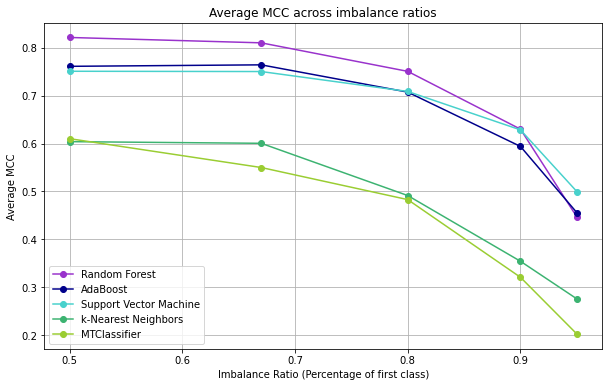

In [72]:
#compute MCCs for each dataset
for ratio in results:
    validation_metrics = results[ratio]["validation"]
    if "Matthews Correlation Coefficient" in validation_metrics:
        for clf_name in classifiers.keys():
            avg_mcc = np.mean(validation_metrics["Matthews Correlation Coefficient"][clf_name])
            results[ratio]["average"][clf_name]["Matthews Correlation Coefficient"] = avg_mcc
            
#plot
plt.figure(figsize=(10, 6))

colors = {
    "Random Forest": 'darkorchid',
    "AdaBoost": 'darkblue',
    "Support Vector Machine": 'mediumturquoise',
    "k-Nearest Neighbors": 'mediumseagreen',
    "MTClassifier": 'yellowgreen' 
}
                       
for clf_name in classifiers.keys():
    x = [ratio[0] for ratio in results]
    y = [results[ratio]["average"][clf_name]["Matthews Correlation Coefficient"] for ratio in results]
    plt.plot(x, y, label=clf_name, color=colors.get(clf_name), marker='o')

plt.title('Average MCC across imbalance ratios')
plt.xlabel('Imbalance Ratio (Percentage of first class)')
plt.ylabel('Average MCC')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


## 3.2.2. to Number of features

In [73]:
#create 4 datasets with increasing feature counts
feature_counts = [20, 200, 500, 1000]

#ratio of informative features is tied
informative_ratios = [int(0.2 * count) for count in feature_counts]

datasets = []
for n_features, n_informative in zip(feature_counts, informative_ratios):
    X, y = make_classification(n_samples=5000,
                               n_features=n_features,
                               n_informative=n_informative,
                               
                               n_classes=2,
                               n_clusters_per_class=1,
                               weights=[0.3,0.7],
                               class_sep=0.65,
                               flip_y=0.02,
                               
                               random_state=42)
    datasets.append((X, y))

In [74]:
results = {n_features: {"validation": defaultdict(list),
                        "test": defaultdict(float),
                        "time": defaultdict(float)} for n_features in feature_counts}

for n_features, (X, y) in zip(feature_counts, datasets):
    
    #train/test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #cross validation setup
    num_folds = 3
    fold_size = len(X_train) // num_folds
    
    metrics = {
        "Matthews Correlation Coefficient": {},
        "Cohen's Kappa Score": {},
        "Training Time": {},
        "Prediction Time": {}
    }

    for clf_name in classifiers.keys():
        for metric_name in metrics.keys():
            metrics[metric_name][clf_name] = []

    #create folds
    for fold in range(num_folds):
        print(f"Dataset with {n_features} features, Evaluating fold {fold + 1}...")
        
        #train/val split
        val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
        train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
        
        X_val_fold = X_train[val_indices]
        y_val_fold = y_train[val_indices]
        X_train_fold = X_train[train_indices]
        y_train_fold = y_train[train_indices]
        
        #evaluate
        for clf_name, clf in classifiers.items():
            print(f"    Evaluating {clf_name}...")

            start_time = time.time()
            clf.fit(X_train_fold, y_train_fold)
            end_time = time.time()
            metrics["Training Time"][clf_name].append(end_time - start_time)

            start_time = time.time()
            y_pred = clf.predict(X_val_fold)
            end_time = time.time()
            metrics["Prediction Time"][clf_name].append(end_time - start_time)

            metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
            metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
            
            #results
            cohen_key = "Cohen's Kappa Score"
            print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
                  f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
            print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
                  f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

    #store results
    results[n_features]["validation"] = metrics

Dataset with 20 features, Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.851, Cohen's Kappa Score: 0.849
    Training Time: 1.639s, Prediction Time: 0.046s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.833, Cohen's Kappa Score: 0.833
    Training Time: 3.658s, Prediction Time: 0.049s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.727, Cohen's Kappa Score: 0.727
    Training Time: 0.989s, Prediction Time: 0.118s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.574, Cohen's Kappa Score: 0.565
    Training Time: 0.001s, Prediction Time: 0.104s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.577, Cohen's Kappa Score: 0.535
    Training Time: 0.351s, Prediction Time: 0.112s

Dataset with 20 features, Evaluating fold 2...
    Ev

    MTClassifier - Matthews Correlation Coefficient: 0.166, Cohen's Kappa Score: 0.115
    Training Time: 1.117s, Prediction Time: 0.231s

Dataset with 1000 features, Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.000, Cohen's Kappa Score: 0.000
    Training Time: 13.982s, Prediction Time: 0.067s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.369, Cohen's Kappa Score: 0.339
    Training Time: 700.357s, Prediction Time: 0.524s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.555, Cohen's Kappa Score: 0.527
    Training Time: 19.736s, Prediction Time: 2.152s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.370, Cohen's Kappa Score: 0.322
    Training Time: 0.002s, Prediction Time: 0.187s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coeffic

### Plotting results

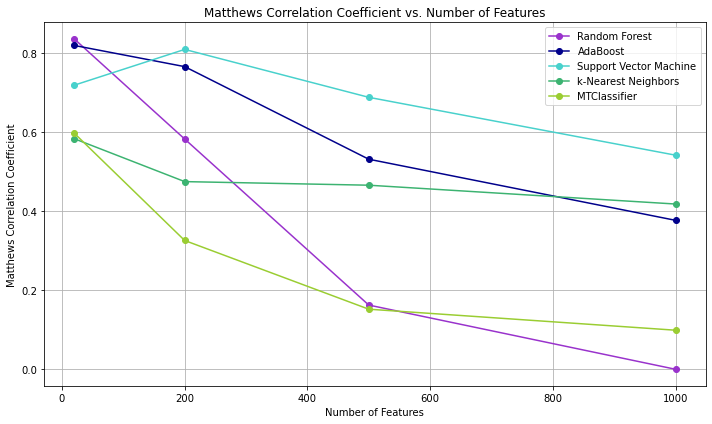

In [75]:
#plot
colors = {
    "Random Forest": 'darkorchid',
    "AdaBoost": 'darkblue',
    "Support Vector Machine": 'mediumturquoise',
    "k-Nearest Neighbors": 'mediumseagreen',
    "MTClassifier": 'yellowgreen' 
}

plt.figure(figsize=(10, 6))

for clf_name in classifiers.keys():
    mcc_values = [np.mean(results[n_features]["validation"]["Matthews Correlation Coefficient"][clf_name]) for n_features in feature_counts]
    plt.plot(feature_counts, mcc_values, marker='o', label=clf_name, color=colors.get(clf_name))

plt.title("Matthews Correlation Coefficient vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Matthews Correlation Coefficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
